In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import xavier_initializer
import shutil
% matplotlib inline

In [2]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
mnist = input_data.read_data_sets('MINST_data/', one_hot=True)

Extracting MINST_data/train-images-idx3-ubyte.gz
Extracting MINST_data/train-labels-idx1-ubyte.gz
Extracting MINST_data/t10k-images-idx3-ubyte.gz
Extracting MINST_data/t10k-labels-idx1-ubyte.gz


In [4]:
class GAN:
    '''
    <Configuration info>
    ID : Model ID
    n_iter : Total # of iterations
    n_prt : Loss print cycle
    n_input : Dimension of input
    n_output : Dimension of output
    n_batch : Size of batch
    n_save : Model save cycle
    n_history : Train/Test loss save cycle
    LR : Learning rate
    
    <Configuration example>
    config = {
        'ID' : 'test_NN',
        'n_iter' : 5000,
        'g_iter' : 1,
        'd_iter' : 1,
        'n_dist' : 10,
        'n_prt' : 100,
        'n_input' : 784,
        'n_output' : 10,
        'n_batch' : 50,
        'n_save' : 1000,
        'n_history' : 50,
        'LR' : 0.0001
    }
    '''
    
    def __init__(self, config):
        self.ID = config['ID']
        self.n_iter = config['n_iter']
        self.g_iter = config['g_iter']
        self.d_iter = config['d_iter']
        self.n_dist = config['n_dist']
        self.n_prt = config['n_prt']
        self.n_input = config['n_input']
        self.n_output = config['n_output']
        self.n_batch = config['n_batch']
        self.n_save = config['n_save']
        self.n_history = config['n_history']
        self.LR = config['LR']
        
        self.history = {
            'loss_d' : [],
            'loss_g' : []
        }
        
        self.checkpoint = 0
        self.path = './{}'.format(self.ID)
        try: 
            os.mkdir(self.path)
            os.mkdir('{0}/{1}'.format(self.path, 'checkpoint'))
        except FileExistsError:
            msg = input('[FileExistsError] Will you remove directory? [Y/N] ')
            if msg == 'Y': # or debug 
                shutil.rmtree(self.path)
                os.mkdir(self.path)
                os.mkdir('{0}/{1}'.format(self.path, 'checkpoint'))
            else: 
                print('Please choose another ID')
                assert 0
        
        self.fake = 0
        self.real = 1
        
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.dist = tf.placeholder(tf.float32, [None, self.n_dist])
            self.x = tf.placeholder(tf.float32, [None, self.n_input])
            
            self.generated_img = self.generator(self.dist)['output']
            self.discr_g = self.discriminator(self.generated_img)['output']
            self.discr_x = self.discriminator(self.x, reuse=True)['output']
            
            self.loss_g = self.compute_loss_g(self.discr_g)
            self.loss_d = self.compute_loss_d(self.discr_g, self.discr_x)
            
            self.optm = tf.train.AdamOptimizer(self.LR, name='optm')
            
            self.optm_g = self.optm.minimize(self.loss_g, var_list=self.graph.get_collection('variables', 'generator'))
            self.optm_d = self.optm.minimize(self.loss_d, var_list=self.graph.get_collection('variables', 'discriminator'))
            
            self.saver = tf.train.Saver(max_to_keep=None)
            self.init = tf.global_variables_initializer()
     
        self.sess = tf.Session(graph=self.graph, config=tf.ConfigProto(allow_soft_placement=True))
        self.sess.run(self.init)
    
        print('Model ID : {}'.format(self.ID))
        print('Model saved at : {}'.format(self.path))
        
    def fit(self, data):
        for epoch in range(1, self.n_iter+1):
            train_x, train_y = data.train.next_batch(self.n_batch)
            train_dist = np.random.multivariate_normal(np.zeros(self.n_dist), np.eye(self.n_dist), self.n_batch)
                        
            for i in range(self.d_iter):
                self.sess.run(self.optm_d, feed_dict={self.dist : train_dist, self.x : train_x})
        
            for i in range(self.g_iter):
                self.sess.run(self.optm_g, feed_dict={self.dist : train_dist})
            
            if epoch % self.n_prt == 0:
                loss_g = self.get_loss_g(train_dist)
                loss_d = self.get_loss_d(train_dist, train_x)
                print('Your G_loss ({0}/{1}) : {2}'.format(epoch, self.n_iter, loss_g))
                print('Your D_loss ({0}/{1}) : {2}\n'.format(epoch, self.n_iter, loss_d))

                gen_img = self.sess.run(self.generated_img, feed_dict={self.dist : train_dist})
                plt.imshow(gen_img[0].reshape(28,28))
                plt.show()
                
            if epoch % self.n_save == 0:
                self.checkpoint += self.n_save
                self.save('{0}/{1}/{2}_{3}'.format(self.path, 'checkpoint', self.ID, self.checkpoint))
                
            if epoch % self.n_history == 0:
                loss_g = self.get_loss_g(train_dist)
                loss_d = self.get_loss_d(train_dist, train_x)
                self.history['loss_g'].append(loss_g)
                self.history['loss_d'].append(loss_d)
    
    def fc_layer(self, input_tensor, name, n_out, activate_fn=tf.nn.relu):
        n_in = input_tensor.get_shape()[-1].value
        with tf.variable_scope(name):
            weight = tf.get_variable('weight', [n_in, n_out], tf.float32, xavier_initializer())
            bias = tf.get_variable('bias', [n_out], tf.float32, tf.constant_initializer(0.0))
            logits = tf.add(tf.matmul(input_tensor, weight), bias, name='logits')
            if activate_fn is None : return logits
            else: return activate_fn(logits, name='activation')
            
    def generator(self, x):
        with tf.variable_scope('generator'):
            generator1 = self.fc_layer(x, 'generator1', 100)
            generator2 = self.fc_layer(generator1, 'generator2', 300)
            generator3 = self.fc_layer(generator2, 'generator3', 500)
            output = self.fc_layer(generator3, 'output', self.n_input, activate_fn=None)
        return {
            'generator1' : generator1,
            'generator2' : generator2,
            'generator3' : generator3,
            'output' : output,
        }

    def discriminator(self, x, reuse=False):
        with tf.variable_scope('discriminator', reuse=reuse):
            discriminator1 = self.fc_layer(x, 'discriminator1', 500)
            discriminator2 = self.fc_layer(discriminator1, 'discriminator2', 300)
            discriminator3 = self.fc_layer(discriminator2, 'discriminator3', 100)
            output = self.fc_layer(discriminator3, 'output', 1, activate_fn=None)
        return {
            'discriminator1' : discriminator1,
            'discriminator2' : discriminator2,
            'discriminator3' : discriminator3,
            'output' : output,
        }
            
    def compute_loss_g(self, output):
        with tf.variable_scope('compute_loss_g'):
            loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=output, labels=tf.ones_like(output))
            loss = tf.reduce_mean(loss)
        return loss
    
    def compute_loss_d(self, output, real_img):
        with tf.variable_scope('compute_loss_d'):
            loss1 = tf.nn.sigmoid_cross_entropy_with_logits(logits=output, labels=tf.zeros_like(output))
            loss1 = tf.reduce_mean(loss1)
            loss2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=real_img, labels=tf.ones_like(real_img))
            loss2 = tf.reduce_mean(loss2)
            loss = tf.add(loss1, loss2)
        return loss
 
    def get_loss_g(self, dist):
        return self.sess.run(self.loss_g, feed_dict={self.dist : dist})

    def get_loss_d(self, dist, x):
        return self.sess.run(self.loss_d, feed_dict={self.dist : dist, self.x : x})
    
    ## Save/Restore
    def save(self, path):
        self.saver.save(self.sess, path)
        
    def load(self, path):
        self.saver.restore(self.sess, path)
        checkpoint = path.split('_')[-1]
        self.checkpoint = int(checkpoint)
        print('Model loaded from file : {}'.format(path))

In [5]:
config = {
        'ID' : 'test_GAN',
        'n_iter' : 100000,
        'g_iter' : 1,
        'd_iter' : 3,
        'n_dist' : 50,
        'n_prt' : 2000,
        'n_input' : 784,
        'n_output' : 10,
        'n_batch' : 50,
        'n_save' : 2000,
        'n_history' : 500,
        'LR' : 0.0006
    }

In [6]:
model = GAN(config)

[FileExistsError] Will you remove directory? [Y/N] Y
Model ID : test_GAN
Model saved at : ./test_GAN


Your G_loss (2000/100000) : 18.40534210205078
Your D_loss (2000/100000) : 8.655464625917375e-06



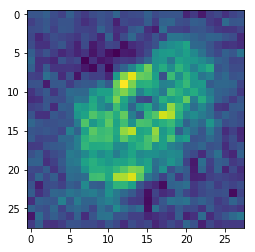

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_2000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (4000/100000) : 7.3450446128845215
Your D_loss (4000/100000) : 0.0009961659088730812



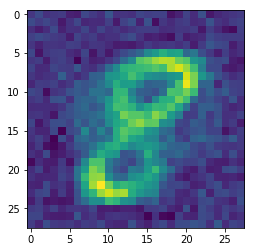

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_4000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (6000/100000) : 33.2318115234375
Your D_loss (6000/100000) : 0.005833258852362633



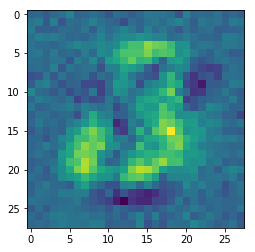

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_6000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (8000/100000) : 7.692710876464844
Your D_loss (8000/100000) : 0.05684905871748924



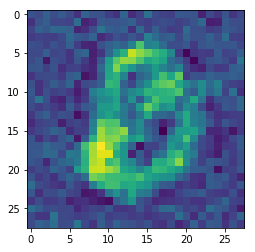

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_8000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (10000/100000) : 9.378591537475586
Your D_loss (10000/100000) : 0.0011819275096058846



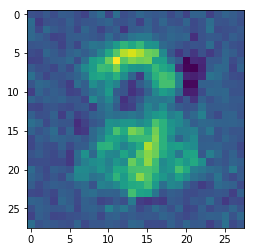

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_10000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (12000/100000) : 9.352405548095703
Your D_loss (12000/100000) : 0.006667762994766235



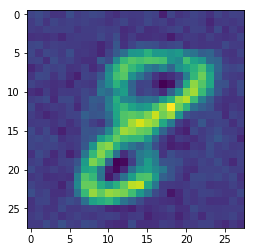

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_12000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (14000/100000) : 6.860418319702148
Your D_loss (14000/100000) : 0.03406679257750511



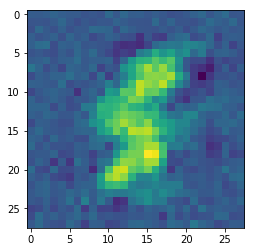

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_14000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (16000/100000) : 9.060220718383789
Your D_loss (16000/100000) : 0.007227299734950066



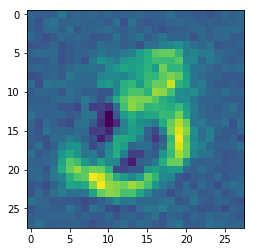

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_16000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (18000/100000) : 10.514501571655273
Your D_loss (18000/100000) : 0.005157142877578735



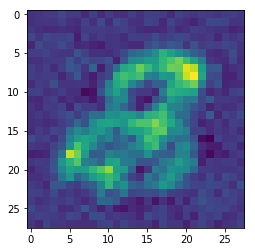

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_18000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (20000/100000) : 6.74304723739624
Your D_loss (20000/100000) : 0.02363581210374832



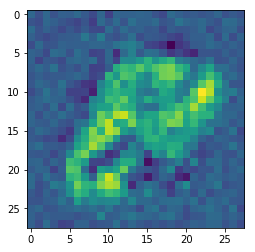

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_20000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (22000/100000) : 6.201743125915527
Your D_loss (22000/100000) : 0.034157466143369675



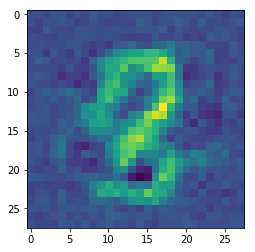

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_22000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (24000/100000) : 7.142320156097412
Your D_loss (24000/100000) : 0.045539647340774536



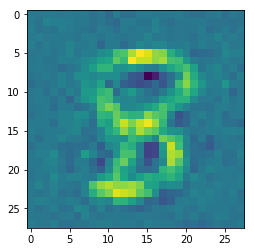

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_24000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (26000/100000) : 8.497904777526855
Your D_loss (26000/100000) : 0.0202801413834095



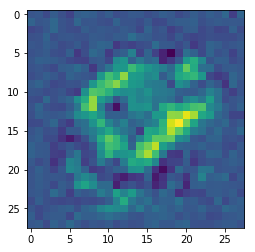

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_26000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (28000/100000) : 7.214033603668213
Your D_loss (28000/100000) : 0.009415140375494957



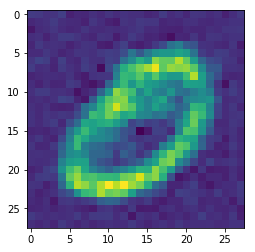

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_28000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (30000/100000) : 6.098886966705322
Your D_loss (30000/100000) : 0.02709265798330307



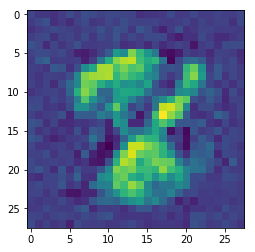

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_30000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (32000/100000) : 7.448256492614746
Your D_loss (32000/100000) : 0.010873900726437569



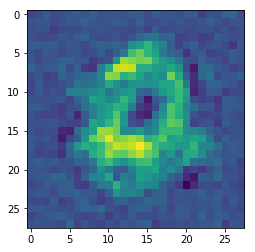

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_32000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (34000/100000) : 7.269947052001953
Your D_loss (34000/100000) : 0.021286584436893463



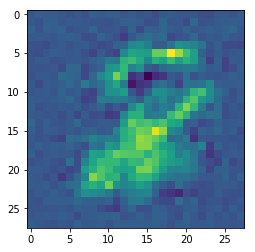

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_34000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (36000/100000) : 6.859875202178955
Your D_loss (36000/100000) : 0.023813869804143906



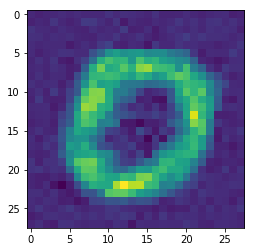

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_36000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (38000/100000) : 6.248134136199951
Your D_loss (38000/100000) : 0.017516426742076874



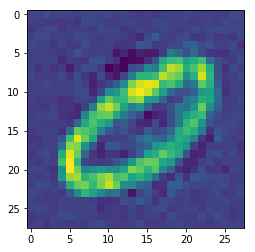

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_38000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (40000/100000) : 7.309187889099121
Your D_loss (40000/100000) : 0.004985068459063768



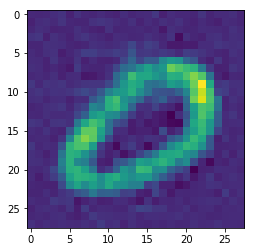

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_40000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (42000/100000) : 7.514348983764648
Your D_loss (42000/100000) : 0.014086763374507427



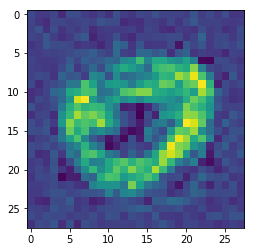

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_42000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (44000/100000) : 6.581817626953125
Your D_loss (44000/100000) : 0.009965542703866959



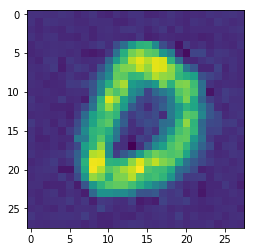

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_44000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (46000/100000) : 8.711645126342773
Your D_loss (46000/100000) : 0.02914082258939743



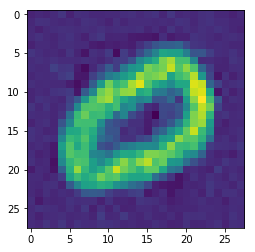

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_46000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (48000/100000) : 5.915696144104004
Your D_loss (48000/100000) : 0.13456302881240845



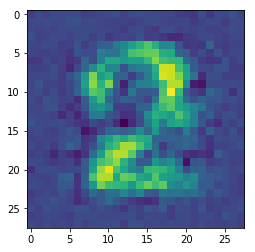

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_48000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (50000/100000) : 6.514767169952393
Your D_loss (50000/100000) : 0.021873565390706062



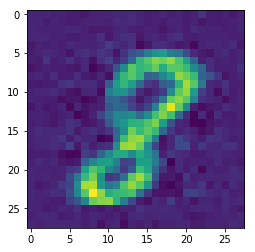

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_50000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (52000/100000) : 5.476112365722656
Your D_loss (52000/100000) : 0.01416533812880516



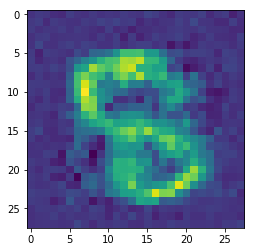

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_52000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (54000/100000) : 5.8856658935546875
Your D_loss (54000/100000) : 0.016741281375288963



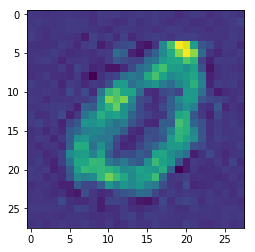

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_54000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (56000/100000) : 8.127123832702637
Your D_loss (56000/100000) : 0.001875509973615408



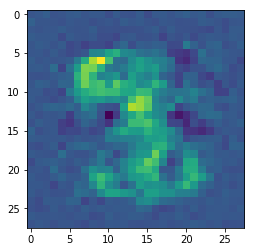

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_56000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (58000/100000) : 6.9301347732543945
Your D_loss (58000/100000) : 0.019332680851221085



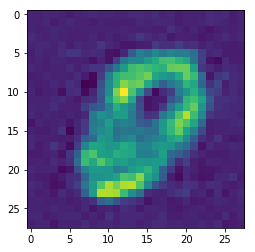

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_58000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (60000/100000) : 5.323095321655273
Your D_loss (60000/100000) : 0.06946904212236404



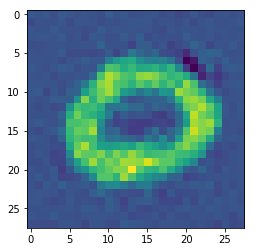

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_60000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (62000/100000) : 4.094457626342773
Your D_loss (62000/100000) : 0.09185133874416351



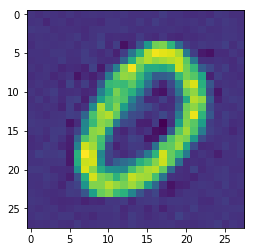

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_62000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (64000/100000) : 4.984708309173584
Your D_loss (64000/100000) : 0.12531408667564392



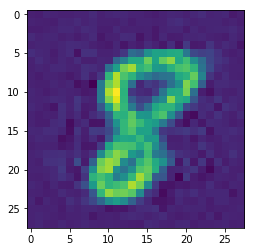

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_64000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (66000/100000) : 7.412640571594238
Your D_loss (66000/100000) : 0.005204163491725922



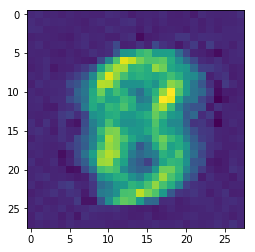

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_66000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (68000/100000) : 8.230643272399902
Your D_loss (68000/100000) : 0.004372410010546446



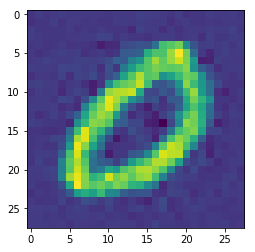

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_68000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (70000/100000) : 7.5512566566467285
Your D_loss (70000/100000) : 0.002592304954305291



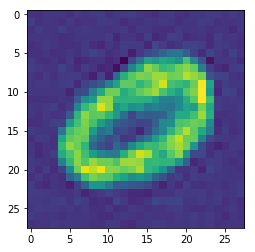

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_70000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (72000/100000) : 5.9501848220825195
Your D_loss (72000/100000) : 0.014639013446867466



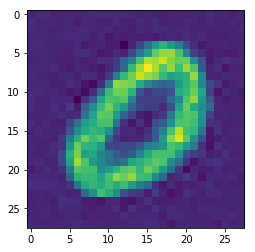

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_72000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (74000/100000) : 6.1381001472473145
Your D_loss (74000/100000) : 0.0071829636581242085



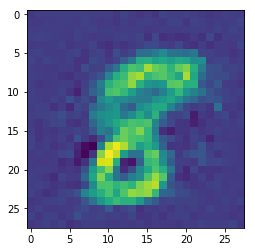

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_74000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (76000/100000) : 6.191408157348633
Your D_loss (76000/100000) : 0.005947659723460674



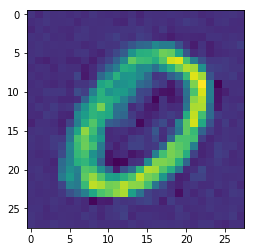

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_76000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (78000/100000) : 8.372690200805664
Your D_loss (78000/100000) : 0.003900254610925913



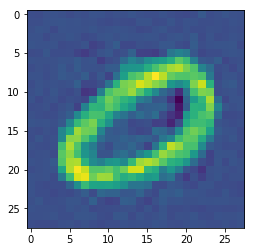

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_78000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (80000/100000) : 5.348564147949219
Your D_loss (80000/100000) : 0.00996402557939291



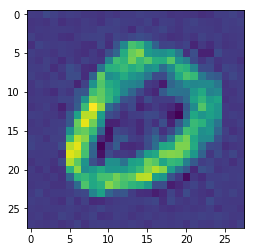

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_80000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (82000/100000) : 6.722436904907227
Your D_loss (82000/100000) : 0.0074629285372793674



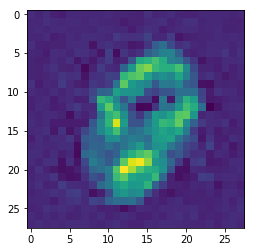

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_82000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (84000/100000) : 6.670498847961426
Your D_loss (84000/100000) : 0.005575744900852442



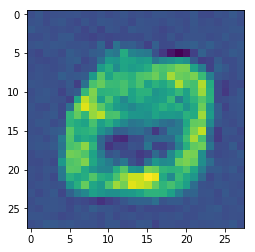

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_84000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (86000/100000) : 8.527732849121094
Your D_loss (86000/100000) : 0.004805653356015682



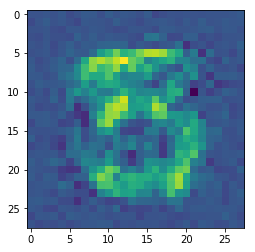

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_86000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (88000/100000) : 7.63901948928833
Your D_loss (88000/100000) : 0.09369758516550064



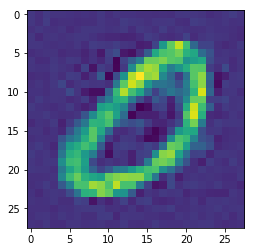

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_88000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (90000/100000) : 7.384271144866943
Your D_loss (90000/100000) : 0.0031525958329439163



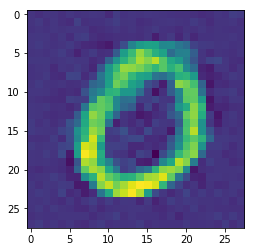

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_90000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (92000/100000) : 6.352891445159912
Your D_loss (92000/100000) : 0.008901404216885567



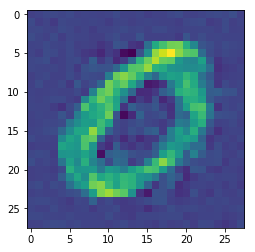

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_92000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (94000/100000) : 6.983067035675049
Your D_loss (94000/100000) : 0.004420986399054527



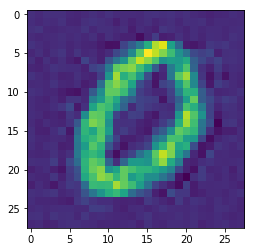

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_94000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (96000/100000) : 6.328413009643555
Your D_loss (96000/100000) : 0.011005251668393612



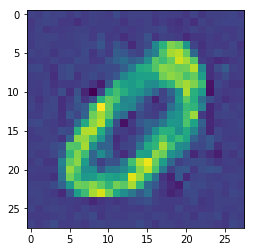

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_96000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (98000/100000) : 6.595473766326904
Your D_loss (98000/100000) : 0.04920443892478943



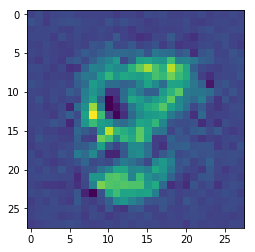

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_98000 is not in all_model_checkpoint_paths. Manually adding it.
Your G_loss (100000/100000) : 6.694708824157715
Your D_loss (100000/100000) : 0.007119897287338972



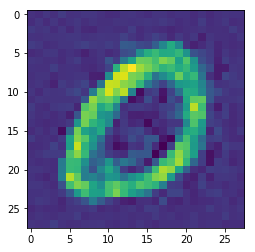

INFO:tensorflow:./test_GAN/checkpoint/test_GAN_100000 is not in all_model_checkpoint_paths. Manually adding it.


In [7]:
model.fit(mnist)

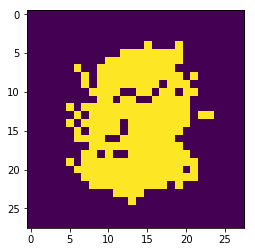

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00

In [22]:
train_x, train_y = mnist.train.next_batch(2)
train_dist = np.random.multivariate_normal(np.zeros(50), np.eye(50), 2)


gen_img = model.sess.run(model.generated_img, feed_dict={model.dist : train_dist})
plt.imshow(gen_img[0].reshape(28,28))
plt.show()
print(gen_img[0])